### Load the California Housing dataset

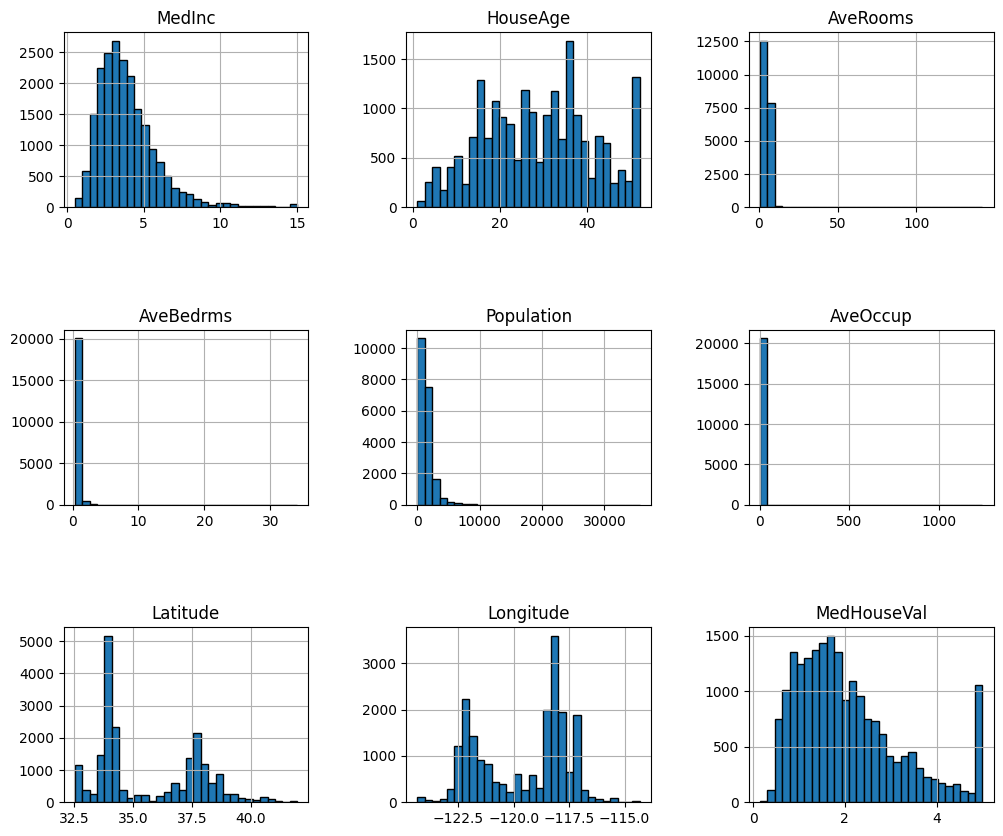

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing

cali_housing = fetch_california_housing(as_frame=True)
cali_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

### Split to train/test and train NAM model

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from train import *

seed = 0
rng_key = jax.random.PRNGKey(seed)
data = cali_housing.frame.to_numpy()
X, y = data[:,:-1], data[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed, test_size=0.2)
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# learning rate, batch size, regularization coefficients obtained from the paper (see A.5)
lr_0 = 0.00674
batch_size = 1024
l2_reg, output_reg = 1e-6, 1e-3
epochs = 500
# schedule_fn = optax.exponential_decay(lr_0, epochs, decay_rate=0.995)
schedule_fn = lambda t: lr_0
model, state, val_losses, test_loss = train_loop(seed, x_train, x_val, x_test, y_train, y_val, y_test,
                                                epochs, batch_size, output_reg, 0.0,
                                                 schedule_fn, l2_reg, feature_dropout=0.0, shallow=False,
                                                 activation="relu", num_basis_functions=32)

In [3]:
test_loss

DeviceArray(0.57008696, dtype=float32)

### Plot feature importance
- Code taken and modifiend from this [colab](https://colab.research.google.com/drive/1E3_t7Inhol-qVPmFNq1Otj9sWt1vU_DQ?usp=sharing)

In [31]:
def compute_mean_feature_importance(model, params, key, x, cols):
    _, per_feat_preds = model.apply(params,key, x, False)
    feature_predictions = np.array(per_feat_preds)
    mean_feat_preds = np.mean(feature_predictions, axis=-1)

    feat_importance = {}
    for i, col in enumerate(cols):
        mean_pred = mean_feat_preds[i]
        feat_preds = feature_predictions[i]
        mean_abs_score = np.mean(np.abs(feat_preds - mean_pred[...,None]), axis=-1)
        feat_importance[col] = mean_abs_score

    return feat_importance

def plot_mean_feature_importance(feat_importance, cols, width = 0.3, name="Housing"):
    x1, x2 = zip(*feat_importance.items())
    fig, ax = plt.subplots(figsize=(5, 4))
    ind = np.arange(len(x1))  # the x locations for the groups
    x1_indices = np.argsort(x2)
    cols_here = [cols[i] for i in x1_indices]
    x2_here = [x2[i] for i in x1_indices]

    ax.bar(ind, x2_here, width, label='NAMs')
    ax.set_xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
    ax.set_ylabel('Mean Absolute Score', fontsize='x-large')
    ax.legend(loc='upper left', fontsize='large')
    ax.set_title(f'Overall Importance: {name}', fontsize='x-large')

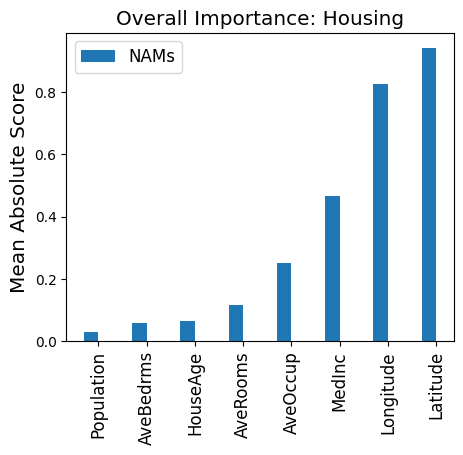

In [32]:
cols = cali_housing.frame.columns.to_list()[:-1]
feature_importance = compute_mean_feature_importance(model, state.params, rng_key, x_test, cols)
plot_mean_feature_importance(feature_importance, cols)

### Plot the graph of each feature prediction

In [72]:
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, single_feats_orig,
                            num_rows, num_cols, n_blocks=5,
                            color=[0.9, 0.5, 0.5], feature_to_use=None):


    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
    max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
    min_max_dif = max_y - min_y
    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif

    if feature_to_use:
        hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

    for i, (name, pred) in enumerate(hist_data_pairs):
        unique_x_data = single_feats_orig[name]
        single_feature_data = single_feats_orig[name]
        ax = plt.subplot(num_rows, num_cols, i+1)
        min_x = np.min(unique_x_data)
        max_x = np.max(unique_x_data)
        x_n_blocks = min(n_blocks, len(unique_x_data))
        segments = (max_x - min_x) / x_n_blocks
        density = np.histogram(single_feature_data, bins=x_n_blocks)
        normed_density = density[0] / np.max(density[0])
        rect_params = []
        for p in range(x_n_blocks):
            start_x = min_x + segments * p
            end_x = min_x + segments * (p + 1)
            d = min(1.0, 0.01 + normed_density[p])
            rect_params.append((d, start_x, end_x))

        for param in rect_params:
            alpha, start_x, end_x = param
            rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x,
                                     max_y - min_y + 1, linewidth=0.01,
                                     edgecolor=color, facecolor=color, alpha=alpha)
            ax.add_patch(rect)

def plot_all_hist(hist_data, single_feats_orig, col_names,
                  num_rows, num_cols,  color_base,
                  size=3.0, min_y=None, max_y=None, alpha=1.0,
                  feature_to_use=None):
    hist_data_pairs = list(hist_data.items())
    hist_data_pairs.sort(key=lambda x: x[0])
    if min_y is None:
        min_y = np.min([np.min(a) for _, a in hist_data_pairs])
    if max_y is None:
        max_y = np.max([np.max(a) for _, a in hist_data_pairs])
    min_max_dif = max_y - min_y
    min_y = min_y - 0.01 * min_max_dif
    max_y = max_y + 0.01 * min_max_dif

    total_mean_bias = 0

    if feature_to_use:
        hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

    for i, (name, pred) in enumerate(hist_data_pairs):
        mean_pred = np.mean(pred)
        total_mean_bias += mean_pred
        unique_x_data = single_feats_orig[name]
        plt.subplot(num_rows, num_cols, i+1)
        plt.scatter(unique_x_data, pred - mean_pred, color=color_base,
                 s=size, alpha=alpha)
        plt.xticks(fontsize='x-large')


        plt.ylim(min_y, max_y)
        plt.yticks(fontsize='x-large')
        min_x = np.min(unique_x_data)
        max_x = np.max(unique_x_data)
        plt.xlim(min_x, max_x)
        if i % num_cols == 0:
            plt.ylabel('House Price Contribution', fontsize='x-large')
        plt.xlabel(col_names[i], fontsize='x-large')


In [73]:
p = x_test.shape[1]
x_test_orig = scaler.inverse_transform(x_test)
single_feats_orig = {}
for i, col in enumerate(cols):
    single_feats_orig[col] = x_test_orig[:,i]


_, feature_predictions = model.apply(state.params, rng_key, x_test)
hist_data = {col: predictions for col, predictions in zip(cols, feature_predictions)}

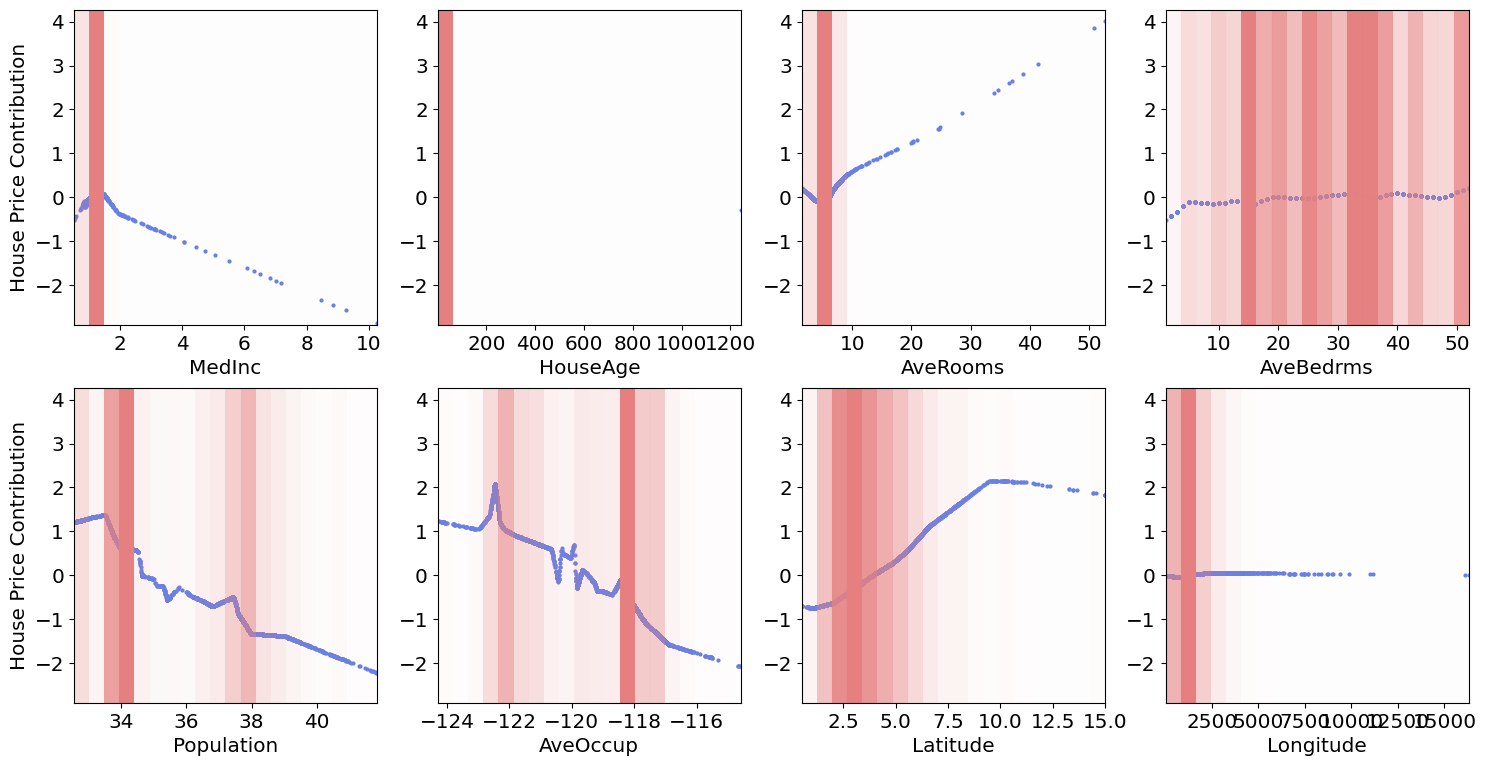

In [74]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  4
N_BLOCKS =  20
NUM_ROWS = int(np.ceil(p / NUM_COLS))

MIN_Y = None
MAX_Y = None

fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

plot_all_hist(hist_data, single_feats_orig, cols, NUM_ROWS, NUM_COLS, COLORS[2],
              min_y=MIN_Y, max_y=MAX_Y, feature_to_use=cols, size=4)

shade_by_density_blocks(hist_data,single_feats_orig ,NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=cols)